In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer

In [106]:
# read the data

# keep_default_na=False reads empty cells as '', which I found temporarily helpful
# we may want to take that out later

flights = pd.read_csv('../data/ntsb-sample-2013.csv')

In [107]:
# Dropped columns and reasons for dropping them

# Not relevant
flights.drop(['Mkey', 'ReportNo', 'N#', 'SerialNumber', 'ReportType', 'ReportStatus', 'RepGenFlag', 
              'MostRecentReportType', 'OriginalPublishedDate', 'DocketOriginalPublishedDate', 
              'Operator', 'EventID', 'NtsbNo', 'DocketUrl', 'ReportUrl'], axis=1, inplace=True)

# (Almost) all rows have same value
flights.drop(['Country', 'Mode', 'HasSafetyRec', ], axis=1, inplace=True)

# Redundant
flights.drop(['HighestInjuryLevel'], axis=1, inplace=True)


### Possible issues with other variables

Redundancy: 
- FatalInjuryCount + SeriousInjuryCount + MinorInjuryCount = OnboardInjuryCount + OnGroundInjuryCount
- City, State, Latitude, Longitude, AirportID, AirportName

Requires significant processing:
- ProbableCause, Findings
- Make, Model (hundreds of distinct values)
- PurposeOfFlight (26 distinct values, 17 of which have < 1% occurrence rate)

Possible data leakage
- EventType (accident vs. incident)

### Preliminary recommendations (C.J.)
- Drop location column unless it's necessary for train/test split
- Drop make + model column
- Drop 31 rows with EventType == INC, then drop column EventType
- Investigate meanings of entries in PurposeOfFlight column, group into smaller categories
- Drop rows involving multiple aircraft (identifiable by two comma-separated values in a single cell)
- Make dummies for the following:
    - AirCraftDamage
    - WeatherCondition
    - BroadPhaseOfFlight
    - AmateurBuilt

In [108]:
flights.head()

,EventType,EventDate,City,State,FatalInjuryCount,SeriousInjuryCount,MinorInjuryCount,OnboardInjuryCount,OnGroundInjuryCount,ProbableCause,...,AirportName,AmateurBuilt,NumberOfEngines,EngineType,Scheduled,PurposeOfFlight,FAR,AirCraftDamage,WeatherCondition,BroadPhaseofFlight
0,ACC,2013-12-31T13:00:00Z,Salinas,California,0,0,0,0.0,0.0,The pilot's failure to maintain directional co...,...,SALINAS MUNI,false,1,REC,NaN,PERS,091,Substantial,VMC,Landing
1,ACC,2013-12-30T12:40:00Z,Concordia,Kansas,0,0,2,2.0,0.0,The pilot's failure to maintain a proper glide...,...,BLOSSER MUNI,false,1,REC,NaN,PERS,091,Substantial,VMC,Landing
2,ACC,2013-12-29T15:10:00Z,Paradis,Louisiana,0,0,0,0.0,0.0,The collision with a bird which resulted in su...,...,LOUIS ARMSTRONG NEW ORLEANS IN,false,1,REC,NaN,PERS,091,Substantial,VMC,Enroute
3,ACC,2013-12-29T13:53:00Z,Pacoima,California,0,0,2,2.0,0.0,The flight instructor’s inadequate compensatio...,...,WHITEMAN,false,1,REC,NaN,INST,091,Substantial,VMC,Maneuvering
4,ACC,2013-12-29T13:30:00Z,Roberts,Montana,0,0,0,0.0,0.0,The pilot's selection of unsuitable terrain du...,...,Private,false,1,REC,NaN,PERS,091,Substantial,VMC,Taxi


In [109]:
# Drop rows corresponding to multi-aircraft accidents
# indicated by a comma in the column FAR

# Turn blanks into '' so .contains() works
flights.loc[flights['FAR'].isna(), 'FAR'] = ''

multiple_aircraft = flights['FAR'].str.contains(',')
flights = flights[~multiple_aircraft]

In [110]:
# Impute 'None' for NA AirCraftDamage

flights.loc[flights['AirCraftDamage'].isna(), 'AirCraftDamage'] = 'None'
flights.AirCraftDamage.value_counts()

AirCraftDamage
Substantial    1111
Destroyed       137
Minor            30
None             23
Name: count, dtype: int64

In [111]:
flights = pd.get_dummies(flights, 
                         columns=['AmateurBuilt', 'WeatherCondition', 'AirCraftDamage',
                                  'BroadPhaseofFlight'])

In [112]:
flights.columns

Index(['EventType', 'EventDate', 'City', 'State', 'FatalInjuryCount',
       'SeriousInjuryCount', 'MinorInjuryCount', 'OnboardInjuryCount',
       'OnGroundInjuryCount', 'ProbableCause', 'Findings', 'Latitude',
       'Longitude ', 'Make', 'Model', 'AirCraftCategory', 'AirportID',
       'AirportName', 'NumberOfEngines', 'EngineType', 'Scheduled',
       'PurposeOfFlight', 'FAR', 'AmateurBuilt_false', 'AmateurBuilt_true',
       'WeatherCondition_IMC', 'WeatherCondition_Unknown',
       'WeatherCondition_VMC', 'AirCraftDamage_Destroyed',
       'AirCraftDamage_Minor', 'AirCraftDamage_None',
       'AirCraftDamage_Substantial', 'BroadPhaseofFlight_Approach',
       'BroadPhaseofFlight_Emergency Descent', 'BroadPhaseofFlight_Enroute',
       'BroadPhaseofFlight_Initial Climb', 'BroadPhaseofFlight_Landing',
       'BroadPhaseofFlight_Maneuvering', 'BroadPhaseofFlight_Pushback/Tow',
       'BroadPhaseofFlight_Standing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_Taxi', 'Broa

In [ ]:
# Impute 0 for unknown injury counts

# TODO Figure out how to write an imputer and impute the median instead
flights.loc[flights['OnboardInjuryCount'].isna(), 'OnboardInjuryCount'] = 0
flights.loc[flights['OnGroundInjuryCount'].isna(), 'OnGroundInjuryCount'] = 0
flights['InjuryCount'] = flights['OnboardInjuryCount'] + flights['OnGroundInjuryCount']

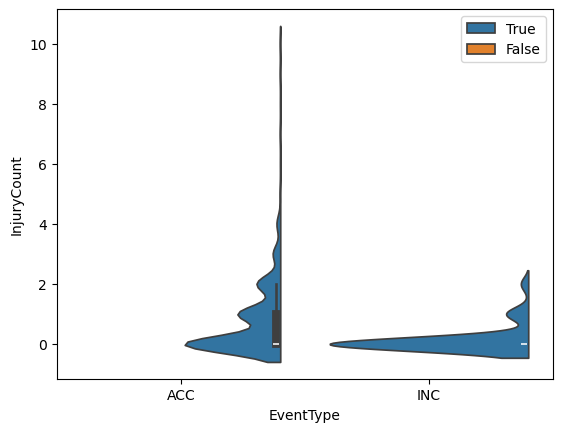

In [83]:
ax = sns.violinplot(
    data=flights.loc[flights['InjuryCount']<190],
    x="EventType", y="InjuryCount", hue=True,
    hue_order=[True, False], split=True,
)